In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning


from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.express as px

import warnings




In [22]:
data_t = pd.read_csv('prison_2010.txt', delimiter='\t', skiprows=2)
data_t = data_t.drop(range(53,58))

for col in data_t.columns:
   if not (data_t[col].apply(lambda x: isinstance(x, str))).all():
       continue
   
   if (data_t[col].apply(lambda x: isinstance(x, str)).all() & data_t[col].str.contains(',')).any():
        try:
            data_t[col] = data_t[col].replace('[\$,]', '', regex=True).astype(float)
        except AttributeError as err:
            print([col])
            break   
data_t = data_t.iloc[1:, :]

In [23]:
def processData(data, flag=False):
    df = data.iloc[:, 2:]
    # Create a boolean mask of NaN values
    nan_mask = df.isnull()

    # Check for any NaN values in each row
    nan_in_row = nan_mask.any(axis=1)

    # Check for any NaN values in each column
    nan_in_col = nan_mask.any(axis=0)
    rows_with_nans = df[nan_in_row]
    cols_with_nans = df.loc[:, nan_in_col]
    if flag:
        print("Features Containing NaN:", cols_with_nans)
    df= df.drop(columns=cols_with_nans).filter(regex='^(?!.*(Population)).*') 
    return df

def getX(df):
       X = df.iloc[:, 2:]
       return X

def runKmeans(data, X, n):
    kmeans = KMeans(n_clusters=n, init = 'k-means++', n_init=1)
    kmeans.fit(X)
    cluster_data = data.copy() 
    cluster_data['Cluster'] = kmeans.labels_
    return cluster_data


def createBarChart(cluster_data, x_axis="Geography", y_axis="empty"): 
    fig = px.bar(cluster_data, x=x_axis, y=y_axis, color='Cluster')
    fig.show()

def stateClusterGraph(cluster_data):
    state_abbreviations = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
    }
    cluster_data['State Abbreviation'] = cluster_data['Geography'].map(state_abbreviations)


    # Create a choropleth map
    fig = px.choropleth(cluster_data, locations='State Abbreviation', locationmode='USA-states', color='Cluster', scope='usa', title='Clusters by State')

    # fig.show()
    return fig


def elbow_method(df, n):
    # Create a new DataFrame with only the columns you want to use for clustering
    X = df.iloc[:,1:6]

    # Perform K-means clustering for different values of K
    inertias = []
    for k in range(1, n):
        kmeans = KMeans(n_clusters=k, init = 'k-means++' , random_state=42, n_init=1).fit(X)
        inertia = kmeans.inertia_
        inertias.append(inertia)

    # Plot the elbow curve to choose the optimal value of K
    plt.plot(range(1, n), inertias, 'bx-')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal K')
    plt.show()

    # create dataframe for elbow plot data
    elbow_data = pd.DataFrame({
        'K': range(1, n),
        'Inertia': inertias
    })
    elbow_data = elbow_data.set_index('K')

    # print(elbow_data)

    # Calculate the slope and second derivative of the inertia curve
    slopes = [inertias[i+1] - inertias[i] for i in range(len(inertias)-1)]
    second_derivatives = [slopes[i+1] - slopes[i] for i in range(len(slopes)-1)]

    # Find the index of the maximum second derivative
    max_index = second_derivatives.index(max(second_derivatives))

    # The optimal value of K is one more than the index of the maximum second derivative
    best_k = max_index + 2
    # print(best_k)

    # return df, elbow_data, inertias, best_k



In [24]:
# Data frames that onyl consider Incarceration rates
rate_df_whole =processData(data_t).filter(regex='^(?!.*(Correctional)).*') 
rate_df_total = rate_df_whole.filter(regex='^(?!.*([Mm]ale)).*') # Total rates
rate_df_male = rate_df_whole.filter(regex='.*(Geography|Male).*') # Male rates
rate_df_female = rate_df_whole.filter(regex='.*(Geography|[Fem]ale).*') # Female rates



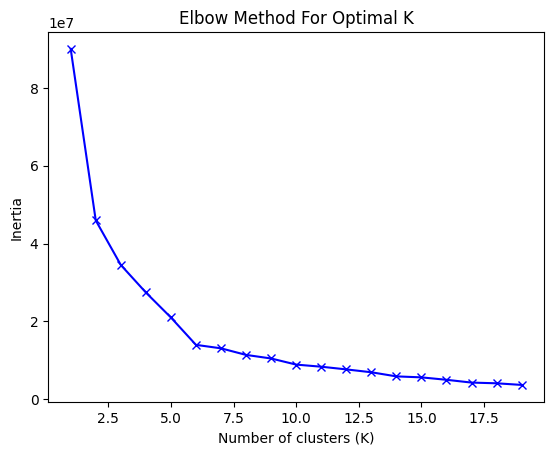

In [25]:
elbow_method(rate_df_whole, 20) ## Used to determine best k for K-means

In [26]:
n=4

In [27]:
# Get graphs with State abbrevations assigned for each
total_rate_fig = stateClusterGraph(runKmeans(rate_df_total, getX(rate_df_total), n)) 
male_rate_fig= stateClusterGraph(runKmeans(rate_df_male, getX(rate_df_male), n))
female_rate_fig = stateClusterGraph(runKmeans(rate_df_female, getX(rate_df_female), n))

In [28]:
# Make 3 subplots for 
# Create a 1x3 grid of subplots with titles and a geo subplot type
fig = make_subplots(
    rows=1,
    cols=3,
    subplot_titles=('Total Rate', 'Male Rate', 'Female Rate'),
    specs=[[{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}]]
)

# Add your figures as subplots
fig.add_trace(total_rate_fig.data[0], row=1, col=1)
fig.add_trace(male_rate_fig.data[0], row=1, col=2)
fig.add_trace(female_rate_fig.data[0], row=1, col=3)

# Update the geo attribute of each subplot to set the scope to 'usa'
fig.update_geos(scope='usa')

# Update the layout to show the subplots
fig.update_layout(title='Clusters by State')

fig.show()

In [29]:
full  = processData(data_t)
stateClusterGraph(runKmeans(full, getX(full), 4))

In [30]:
createBarChart(runKmeans(full, getX(full), 4), x_axis="Geography", y_axis='Total : In Correctional Facilities for Adults')
